# Sars Cov2 PubMed MeSH Terms Network Graph Analysis & Visualization

In [1]:
# data handling
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# netowrk analyis
import networkx as nx

# miscellaneous
from scipy.stats import norm
from tqdm import tqdm
from operator import itemgetter

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# csv file path
file_path =  "/content/drive/MyDrive/04-Work/EDA-Comparison-21st-Epidemics-PubMed/all-covid-19-pubmed-metadata.csv"

# creating dataframe
data = pd.read_csv(file_path)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204668 entries, 0 to 204667
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   PMID    204668 non-null  object
 1   TI      204668 non-null  object
 2   AB      204668 non-null  object
 3   AD      204668 non-null  object
 4   FAU     204668 non-null  object
 5   DP      204668 non-null  object
 6   TA      204668 non-null  object
 7   JT      204668 non-null  object
 8   LA      204668 non-null  object
 9   MH      204668 non-null  object
 10  OAB     204668 non-null  object
 11  OT      204666 non-null  object
 12  PL      204668 non-null  object
 13  PST     204668 non-null  object
 14  PT      204668 non-null  object
 15  RN      204668 non-null  object
 16  SI      204668 non-null  object
dtypes: object(17)
memory usage: 26.5+ MB


In [4]:
data.head(5)

,PMID,TI,AB,AD,FAU,DP,TA,JT,LA,MH,OAB,OT,PL,PST,PT,RN,SI
0,35052023,Does a Mental Health Diagnosis Worsen Outcomes...,NONE,"Department of Psychiatry, Icahn School of Medi...","Vadukapuram, Ramu;Mansuri, Zeeshan;Trivedi, Ch...",2022 Jan 20,Prim Care Companion CNS Disord,The primary care companion for CNS disorders,eng,NONE,NONE,NONE,United States,epublish,Journal Article,NONE,NONE
1,35052021,The Opioid Epidemic and the COVID-19 Pandemic:...,NONE,"Department of Psychiatry, AdventHealth Orlando...","Das, Aparna;Padala, Akshay P;Wilson, Kerrie B",2022 Jan 20,Prim Care Companion CNS Disord,The primary care companion for CNS disorders,eng,NONE,NONE,NONE,United States,epublish,Journal Article,NONE,NONE
2,35052020,Has COVID-19 Complicated Eating Disorder Treat...,Objective: Recent evidence suggests psychosoci...,"Medical Department, Alsana, Thousand Oaks, Cal...","Mascolo, Margherita;Duffy, Mary E;Zehring, Bra...",2022 Jan 20,Prim Care Companion CNS Disord,The primary care companion for CNS disorders,eng,Comorbidity;Pandemics;Adult;*COVID-19;Humans;S...,NONE,NONE,United States,epublish,Journal Article,NONE,NONE
3,35051990,Neutralizing antibodies against the SARS-CoV-2...,The recent emergence of the SARS-CoV-2 Omicron...,"Howard Hughes Medical Institute, Chevy Chase, ...","Pearson, Claire;Grubaugh, Nathan D;Monteiro, V...",2022 Jan 20,Nat Med,Nature medicine,eng,NONE,NONE,NONE,United States,aheadofprint,Journal Article,NONE,NONE
4,35051989,Neutralizing antibodies against the SARS-CoV-2...,The Omicron variant is rapidly becoming the do...,"School of Public Health, LKS Faculty of Medici...","Chen, Chunke;Chan, Karl C K;Lau, Eric H Y;Lam,...",2022 Jan 20,Nat Med,Nature medicine,eng,NONE,NONE,NONE,United States,aheadofprint,Journal Article,NONE,NONE


In [5]:
# entries where MeSH terms are present
data[data['MH']!='NONE'].head()

,PMID,TI,AB,AD,FAU,DP,TA,JT,LA,MH,OAB,OT,PL,PST,PT,RN,SI
2,35052020,Has COVID-19 Complicated Eating Disorder Treat...,Objective: Recent evidence suggests psychosoci...,"Medical Department, Alsana, Thousand Oaks, Cal...","Mascolo, Margherita;Duffy, Mary E;Zehring, Bra...",2022 Jan 20,Prim Care Companion CNS Disord,The primary care companion for CNS disorders,eng,Comorbidity;Pandemics;Adult;*COVID-19;Humans;S...,NONE,NONE,United States,epublish,Journal Article,NONE,NONE
33,35051318,Increased occurrence of temporomandibular join...,PURPOSE: To examine the prevalence of temporom...,"College of Dentistry, University of Florida, G...","Tirrell, Megan;Katz, Joseph",2021 Dec,Am J Dent,American journal of dentistry,eng,Female;Young Adult;*COVID-19;Humans;SARS-CoV-2...,NONE,NONE,United States,ppublish,Journal Article,NONE,NONE
56,35050917,Chronic Wound Telemedicine Models Before and D...,GENERAL PURPOSE: To present the results of a s...,NONE,"Kim, Patrick Jinhyung;Homsi, Haya A;Mufti, Asf...",2022 Feb 1,Adv Skin Wound Care,Advances in skin & wound care,eng,*Telemedicine;Pandemics;Referral and Consultat...,NONE,NONE,United States,ppublish,Journal Article;Review,NONE,NONE
151,35048897,The Psychological Impact of the COVID-19 Pande...,BACKGROUND: This study aims to longitudinally ...,Complutense University of Madrid.,"Munoz, Manuel;Ausin, Berta;Zamorano, Sara;Cast...",2022 Feb,Psicothema,Psicothema,eng,Longitudinal Studies;Anxiety;Depression/epidem...,NONE,NONE,Spain,ppublish,Journal Article,NONE,NONE
152,35048887,The digital divide: amplifying health inequali...,"During COVID-19, health provision and informat...","Good Things Foundation, Sheffield, UK.;Psychos...","Mathers, Alice;Gilbody, Simon;Shiers, David;Pe...",2021 Oct,Br J Psychiatry,The British journal of psychiatry : the journa...,eng,Health Status Disparities;*Mental Disorders/ep...,NONE,*digital divide;*COVID-19;*health inequalities...,England,ppublish,Journal Article,NONE,NONE


In [6]:
def none_entries(column):
  '''Returns missing entries count from each column'''
  
  return dict(column.value_counts()).get('NONE')

In [7]:
for column in data.columns:
  print(f"{column} Missing entries\t-\t{none_entries(data[column])}")

PMID Missing entries	-	2
TI Missing entries	-	617
AB Missing entries	-	56128
AD Missing entries	-	10258
FAU Missing entries	-	1838
DP Missing entries	-	2
TA Missing entries	-	165
JT Missing entries	-	158
LA Missing entries	-	2
MH Missing entries	-	72505
OAB Missing entries	-	204498
OT Missing entries	-	81220
PL Missing entries	-	23
PST Missing entries	-	158
PT Missing entries	-	2
RN Missing entries	-	158321
SI Missing entries	-	202877


In [8]:
# Selecting only those entries which have MeSH Terms available
data_mesh_present = data[data['MH']!='NONE']

In [9]:
mesh_entries = "{:,}".format(len(data_mesh_present.MH))
mesh_entries

'132,163'

## Average Number of MeSH terms association

- Average number of MeSH terms single PubMed articles have.

In [10]:
def mesh_count(entry):
  '''Returns the count of total terms present in single entry
  '''
  temp = []
  for terms in entry.split(';'):
    for term in terms.split('/'):
      temp.append(term.replace('*', ''))

  return len(temp)    

In [11]:
term_count = []
for entry in data_mesh_present.MH:
  term_count.append(mesh_count(entry))

Text(0, 0.5, 'Density')

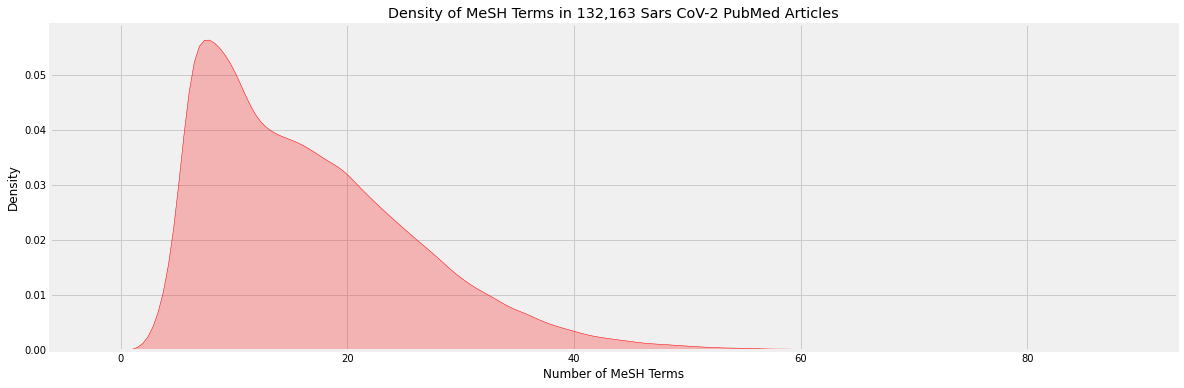

In [12]:
plt.rcParams['figure.figsize'] = [18, 6]

sns.kdeplot(term_count, shade=True, color="r")

plt.title(f"Density of MeSH Terms in {mesh_entries} Sars CoV-2 PubMed Articles")

plt.xlabel('Number of MeSH Terms')

plt.ylabel('Density')

- Right skewness in the distribution of MeSH terms

In [13]:
np.mean(term_count)

16.934951537117044

- On an average there are ~17 MeSH terms per entry (pubmed article).

## Creating MeSH Terms Network Graph 

In [14]:
G = nx.Graph()

for pmid, entry in tqdm(zip(data_mesh_present.PMID, data_mesh_present.MH)):
  main_node = str(pmid).strip()
  G.add_node(main_node)

  for terms in entry.split(';'):
    terms_list = terms.split('/')

    if (len(terms_list))==1:
      primary = terms_list[0].replace('*', '')
      if G.has_node(primary):
        G.add_edge(main_node, primary)
      else:
        G.add_node(primary)
        G.add_edge(main_node, primary)

    else:
      primary = terms_list[0].replace('*', '')
      if G.has_node(primary):
        G.add_edge(main_node, primary)
      else:
        G.add_node(primary)
        G.add_edge(main_node, primary)

      secondary = terms_list[1:]
      for term in secondary:
        term = term.replace('*', '')
        if G.has_node(term):
          G.add_edge(main_node, term)
        else:
          G.add_node(term)
          G.add_edge(main_node, term)

132163it [00:08, 15970.71it/s]


### Shape Of The Network

In [15]:
G.number_of_nodes()

146985

In [16]:
G.number_of_edges()

1882993

In [17]:
density = nx.density(G)
print("Network density:", round(density, 6))

Network density: 0.000174


### Centrality

In [18]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [19]:
len(sorted_degree)

146985

In [20]:
sorted_degree[0]

('Humans', 130253)

## Plotting Top MeSH Terms (Nodes) Among 146,985 Terms (Nodes) By Degree

### Top 50 Nodes

In [21]:
top = 50
print(f"Top {top} nodes by degree:")
for d in sorted_degree[:top]:
    print(d)

Top 50 nodes by degree:
('Humans', 130253)
('COVID-19', 127943)
('SARS-CoV-2', 101980)
('Pandemics', 67930)
('epidemiology', 52684)
('Coronavirus Infections', 40055)
('Pneumonia, Viral', 39919)
('Female', 36195)
('Male', 33946)
('Betacoronavirus', 33175)
('prevention & control', 25135)
('Adult', 23759)
('Middle Aged', 23662)
('virology', 20611)
('diagnosis', 20406)
('methods', 19589)
('Aged', 19421)
('therapy', 16705)
('complications', 14891)
('statistics & numerical data', 14222)
('drug therapy', 13294)
('immunology', 11367)
('therapeutic use', 10976)
('Retrospective Studies', 9935)
('isolation & purification', 9832)
('psychology', 9741)
('genetics', 9313)
('etiology', 9058)
('Young Adult', 8866)
('Adolescent', 8768)
('Child', 8493)
('transmission', 8478)
('metabolism', 8384)
('organization & administration', 8254)
('COVID-19 Vaccines', 7754)
('Aged, 80 and over', 7647)
('United States', 7434)
('blood', 7198)
('Cross-Sectional Studies', 6969)
('Risk Factors', 6826)
('mortality', 6786)

### Top 30 Nodes Plot

Text(0, 0.5, 'Degree')

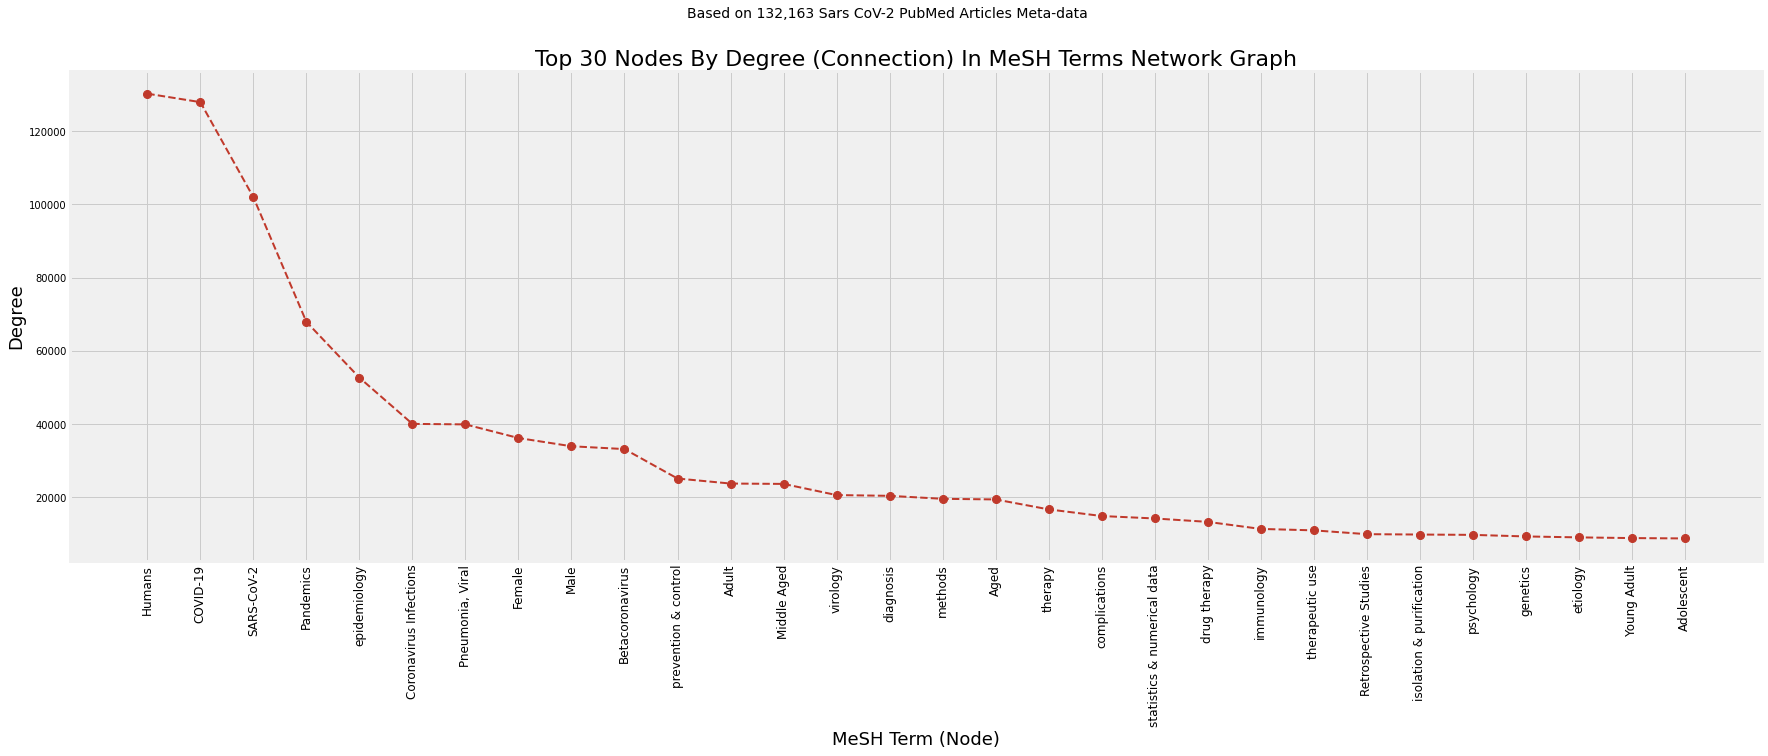

In [22]:
top = 30
top_nodes = sorted_degree[:top]

mesh_nodes = list()
degrees = list()

for mesh_node, degree in top_nodes:
  mesh_nodes.append(mesh_node)
  degrees.append(degree)

title_ = f"Top {top} Nodes By Degree (Connection) In MeSH Terms Network Graph"

plt.rcParams['figure.figsize'] = [27, 9]

plt.xticks(rotation=90)

plt.plot(mesh_nodes, degrees, color='#c0392b', 
         marker='o', linestyle='dashed', 
         linewidth=2, markersize=8)

plt.suptitle(f"Based on {mesh_entries} Sars CoV-2 PubMed Articles Meta-data", 
             fontsize=14)

plt.title(title_, fontsize=22)

plt.xticks(fontsize=12) 

plt.xlabel('MeSH Term (Node)', fontsize=18)

plt.ylabel('Degree', fontsize=18)

### Marker Annotation

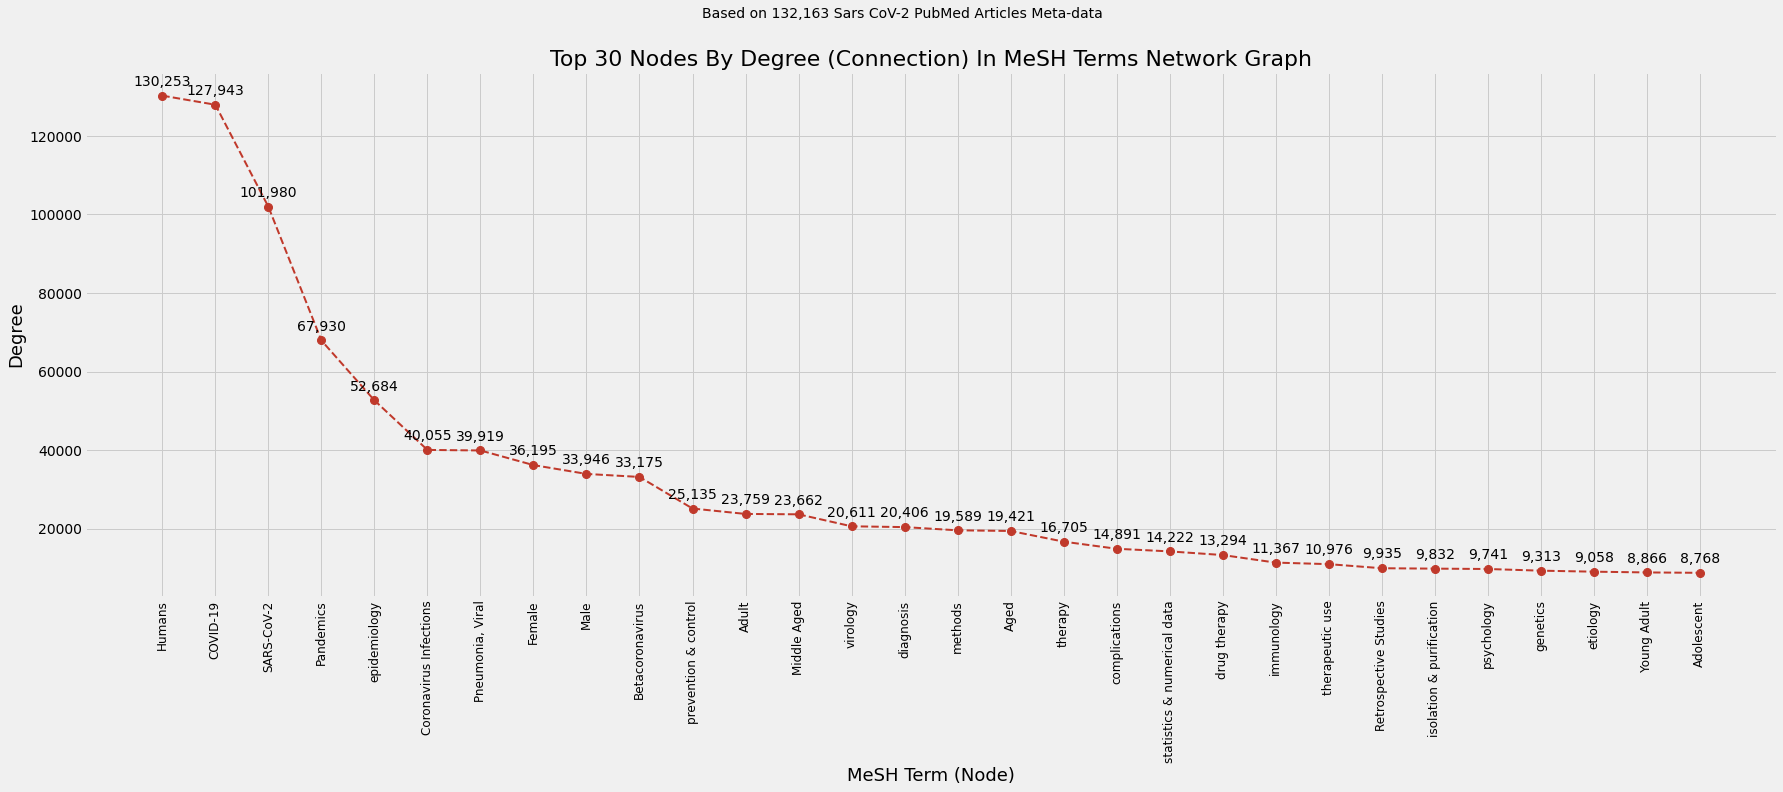

In [23]:
top = 30
top_nodes = sorted_degree[:top]

mesh_nodes = list()
degrees = list()

for mesh_node, degree in top_nodes:
  mesh_nodes.append(mesh_node)
  degrees.append(degree)

plt.style.use('fivethirtyeight')

title_ = f"Top {top} Nodes By Degree (Connection) In MeSH Terms Network Graph"

plt.rcParams['figure.figsize'] = [27, 9]

plt.xticks(rotation=90)

plt.plot(mesh_nodes, degrees, color='#c0392b', 
         marker='o', linestyle='dashed', 
         linewidth=2, markersize=8)

plt.suptitle(f"Based on {mesh_entries} Sars CoV-2 PubMed Articles Meta-data", 
             fontsize=14)

plt.title(title_, fontsize=22)

plt.xticks(fontsize=12) 

plt.xlabel('MeSH Term (Node)', fontsize=18)

plt.ylabel('Degree', fontsize=18)


for x,y in zip(mesh_nodes, degrees):

    label = ("{:,}".format(y))

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()